In [1]:
from astropy.io import fits
import numpy as np
from astropy import units
import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.table import Table
from astropy.time import Time
from astropy.timeseries import LombScargle
from lightkurve.lightcurve import LightCurve
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from scipy.signal import medfilt
from matplotlib.patches import Rectangle

parula = np.load('/Users/belugawhale/parula_colors.npy')

rc = Table.read('../rcParams.txt', format='csv')
for name, val in zip(rc['name'], rc['value']):
    plt.rcParams[name] = val
plt.rcParams['font.size'] = 16

/opt/anaconda3/lib/python3.12/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/belugawhale/.lightkurve/cache. Please move all the files in the legacy directory /Users/belugawhale/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
first = np.load('../data/stacked_3I_2-3.npy', allow_pickle=True).item()
second= np.load('../data/stacked_3I_1-2.npy', allow_pickle=True).item()

In [7]:
summed_tpf = np.nansum(first['raw'][first['good_frames']==1], axis=0)
value = summed_tpf[10,10]

dur = (len(first['raw'][first['good_frames']==1])*200*units.s).value

T = -2.5*np.log10(value/dur)+20.44
v = T + 0.8
print(T, v)

19.614399435552258 20.41439943555226


In [8]:
summed_tpf = np.nansum(second['raw'][second['good_frames']==1], axis=0)
value = summed_tpf[10,10]

dur = (len(second['raw'][second['good_frames']==1])*200*units.s).value

T = -2.5*np.log10(value/dur)+20.44
v = T + 0.8
print(T, v)

19.57436238611094 20.374362386110942


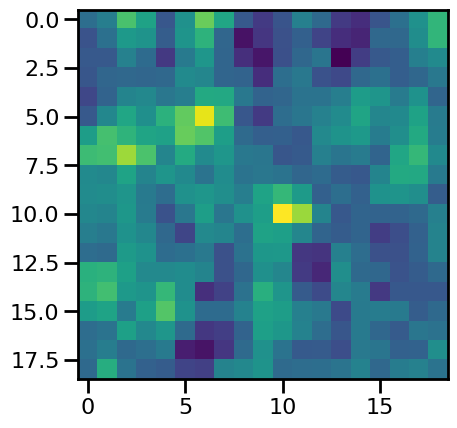

In [3]:
plt.imshow(np.nansum(second['subtracted'][second['good_frames']==1], axis=0))

In [11]:
def convert_mag(counts):
    dur = (len(counts) * 200 * units.s)
    dur = dur.value
    return -2.5 * np.log10(counts/200) + 20.44

(21.0, 18.0)

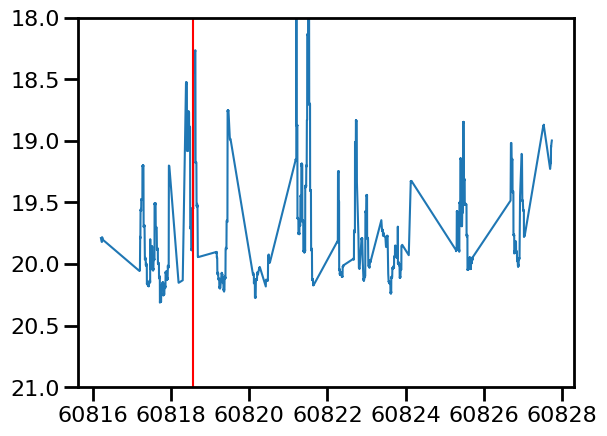

In [46]:
q = second['good_frames'] == 1
plt.plot(second['time'][q], -2.5*np.log10(second['raw'][:,10,10]/200)[q]+20.44)
plt.axvline(second['time'][q][400], color='r')
plt.ylim(21,18)

In [53]:
np.nansum(second['raw'][q][:,10,10],axis=0)

688932.6353302002

In [56]:
len(np.where(q==True)[0])

1552

In [57]:
q = first['good_frames'] == 1
len(np.where(q==True)[0])

1170

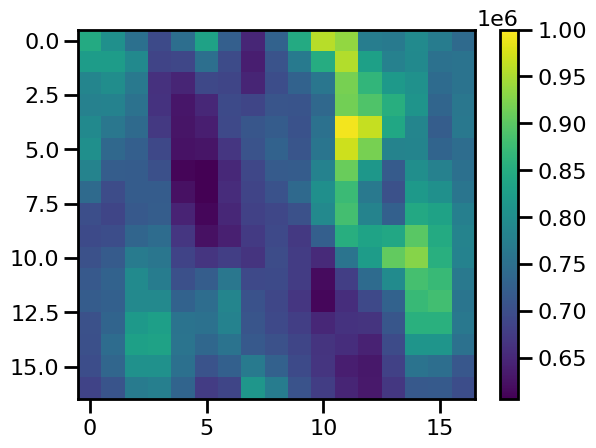

In [51]:
plt.imshow(np.nansum(second['raw'][q][:,2:,2:],axis=0), aspect='auto', vmax=1000000)
plt.colorbar()

500559.93225097656 234000.0 19.614399435552258
688932.6353302002 310400.0 19.57436238611094


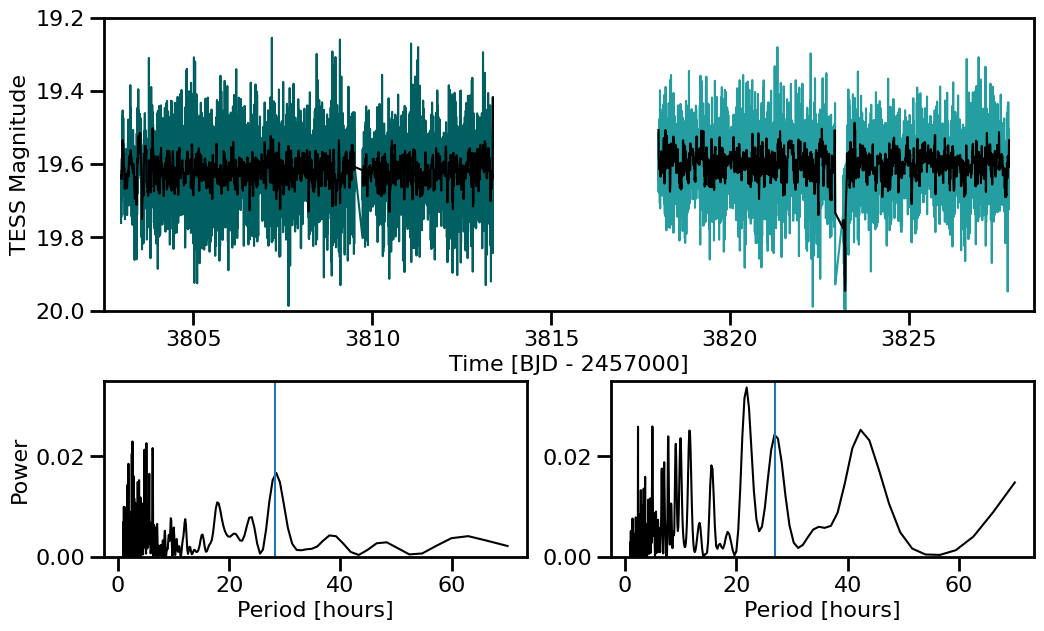

In [61]:
fig = plt.figure(figsize=(12,7))

gs = GridSpec(2, 2, figure=fig, height_ratios=[1,0.6])
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

axes = [ax2, ax3]
colors = ['#005f60', '#249ea0']

total_time = np.array([])
total_lc = np.array([])

for i, ccd in enumerate([first, second]):
    summed_tpf = np.nansum(ccd['raw'][ccd['good_frames']==1], axis=0)
    value = summed_tpf[10,10]
    
    dur = (len(ccd['raw'][ccd['good_frames']==1])*200*units.s).value
    
    T = -2.5*np.log10(value/dur)+20.44
    print(value, dur, T)
    
    lc = ccd['subtracted'][:,10,10] * T
    time = ccd['time'] + 2400000.5 - 2457000

    total_time = np.append(total_time, time)
    total_lc = np.append(total_lc, lc)
    
    if i == 1:
        q = (time > 3818) & (time < 3827.8)
    else:
        q = time > 3800
    
    ax1.plot(time[q], lc[q], color=colors[i])

    m = medfilt(lc[q], 11)
    ax1.plot(time[q], m, 'k')

    frequency, power = LombScargle(time[q]*units.day, lc[q]).autopower(minimum_frequency=1.0/(70.0*units.hour),
                                                                       maximum_frequency=1.0/(1.0*units.hour))
    #axes[i].plot(1.0/frequency, power, color=colors[i])

    frequency, power = LombScargle(time[q]*units.day, m).autopower(minimum_frequency=1.0/(70.0*units.hour),
                                                                       maximum_frequency=1.0/(1.0*units.hour))
    axes[i].plot(1.0/frequency, power, color='k')

    axes[i].set_xlabel('Period [hours]', fontsize=16)


ax1.set_xlabel('Time [BJD - 2457000]', fontsize=16)

ax1.set_ylabel('TESS Magnitude', fontsize=16)
ax1.set_ylim(20., 19.2)
ax1.set_xlim(3802.5, 3828.5)

ax2.set_ylabel('Power', fontsize=16)

ax2.set_ylim(0,0.035)
ax3.set_ylim(0,0.035)

ax2.axvline(28.3)
ax3.axvline(27)

plt.subplots_adjust(hspace=0.3)

plt.savefig('../figures/tess_lightcurve.pdf', dpi=300, bbox_inches='tight')

In [22]:
tab = Table()
tab['time_tbjd'] = total_time
tab['mag'] = total_lc
tab.write('../data/tess_lightcurve.csv', format='csv', overwrite=True)

In [125]:
27.65-27

0.6499999999999986

In [23]:
lc1 = first['subtracted'][:,10,10] * np.nanmedian(convert_mag(first['raw'][:,10,10]))
time1 = first['time'] + 2400000.5 - 2457000
chunks1 = np.append(np.arange(time1[0], time1[-1], 4), time1[-1])

lc2 = second['subtracted'][:,10,10] * np.nanmedian(convert_mag(second['raw'][:,10,10]))
time2 = second['time'] + 2400000.5 - 2457000

chunks2 = np.append(np.arange(time2[0], time2[-1], 4), time2[-1])

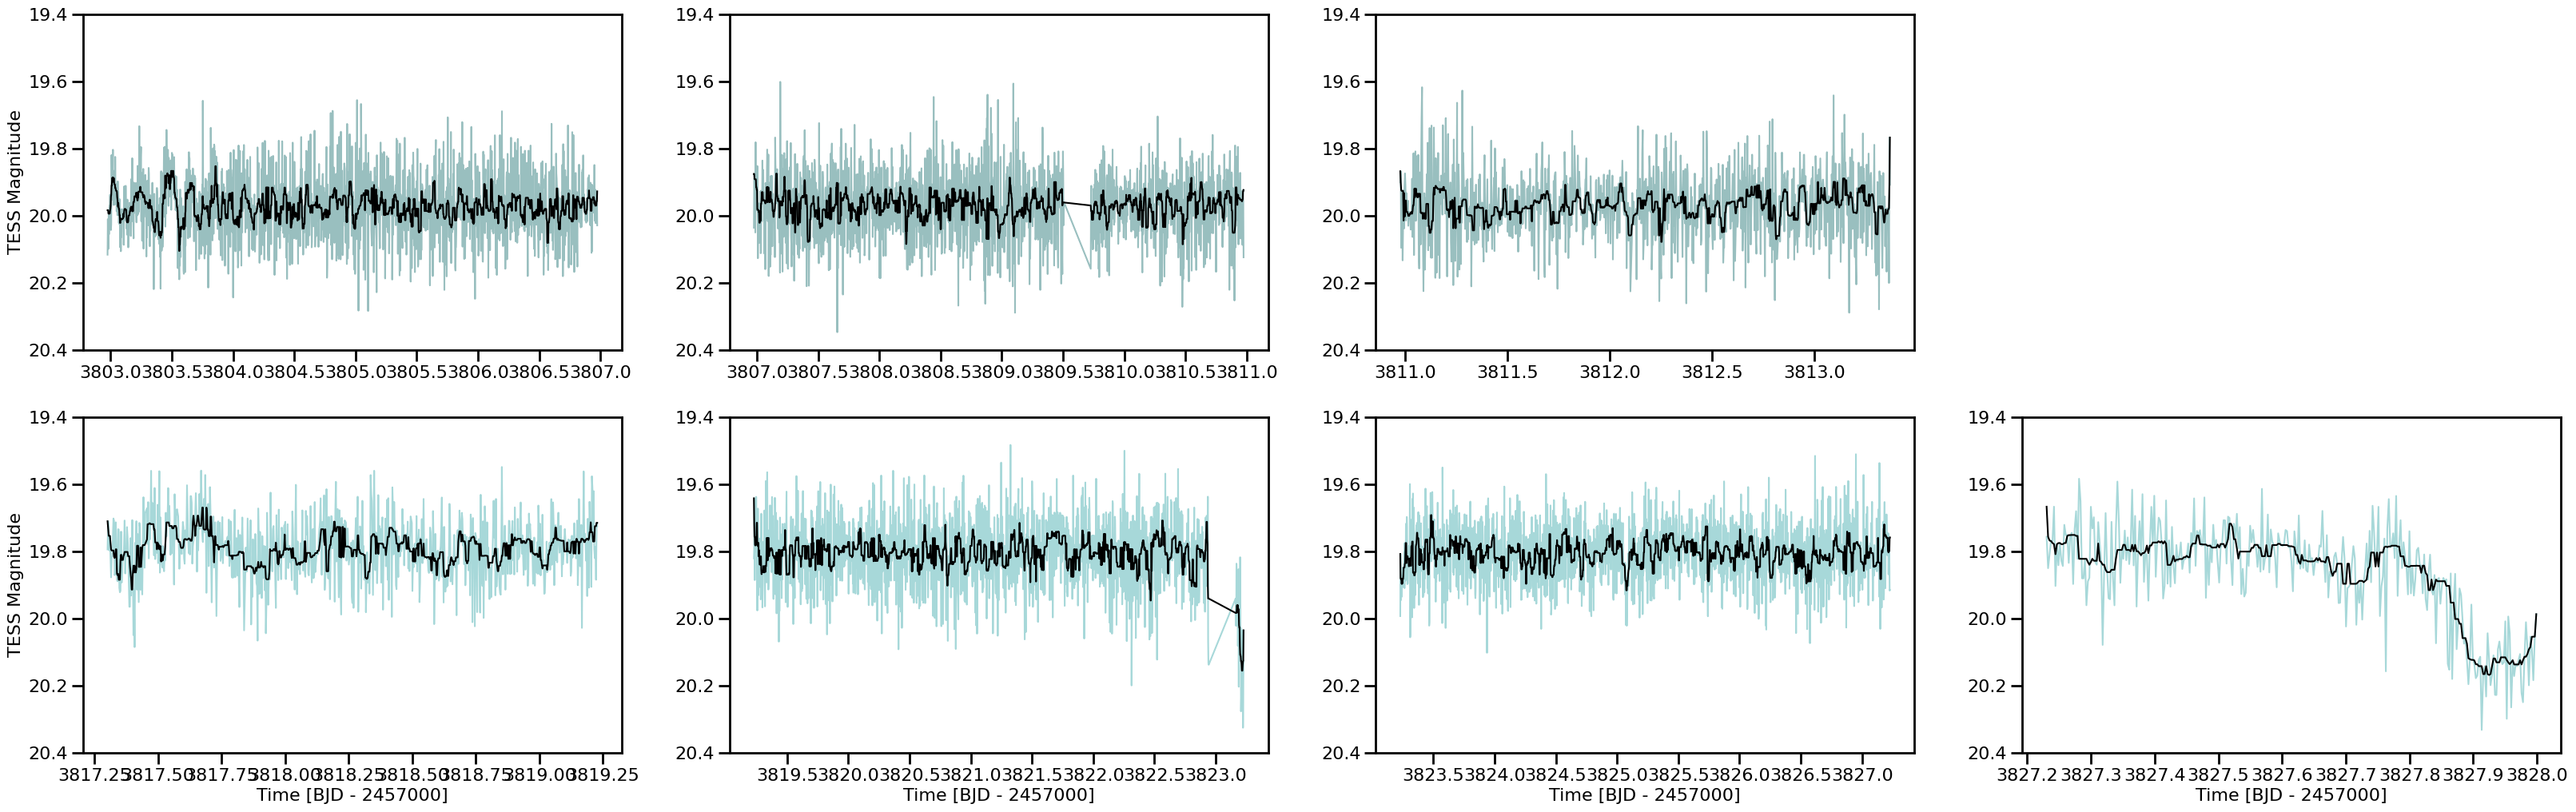

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40,12))
axes = axes.reshape(-1)
fig.set_facecolor('w')

for i in range(len(chunks1)-1):
    q = (time1 >= chunks1[i]) & (time1 < chunks1[i+1])
    axes[i].plot(time1[q], lc1[q], color='#005f60', alpha=0.4)

    m = medfilt(lc1[q], 11)
    axes[i].plot(time1[q], m, color='k')


for i in range(len(chunks2)-1):
    q = (time2 >= chunks2[i]) & (time2 < chunks2[i+1]) & (time2 > 3817.3) & (time2 < 3828)
    axes[i+4].plot(time2[q], lc2[q], color='#249ea0', alpha=0.4)

    m = medfilt(lc2[q], 11)
    axes[i+4].plot(time2[q], m, color='k')

axes[3].set_axis_off()

axes[0].set_ylabel('TESS Magnitude')
axes[4].set_ylabel('TESS Magnitude')

for i in range(4,8):
    axes[i].set_xlabel('Time [BJD - 2457000]')

for i in range(len(axes)):
    axes[i].set_ylim(20.4, 19.4)
    axes[i].set_rasterized(True)

plt.savefig('../figures/broken_lc.png', bbox_inches='tight', dpi=350)

## Background light curve

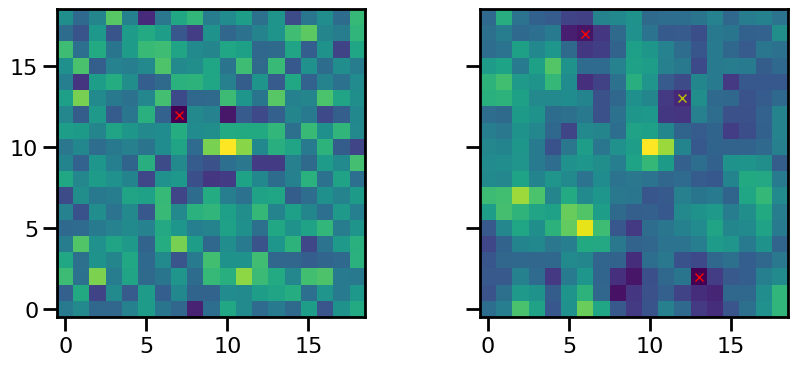

In [111]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)

ax1.imshow(np.nansum(first['subtracted'], axis=0))
ax1.plot(7, 12,'rx')

ax2.imshow(np.nansum(second['subtracted'][second['good_frames']==1], axis=0), origin='lower')
ax2.plot(13,2,'rx')
ax2.plot(6,17,'rx')
ax2.plot(12,13, 'yx')

In [120]:
bkg1 = first['subtracted'][:,7,12] * np.nanmedian(convert_mag(first['raw'][:,7,12]))

bkg2 = second['subtracted'][:,12,13] * np.nanmedian(convert_mag(second['raw'][:,12,13]))

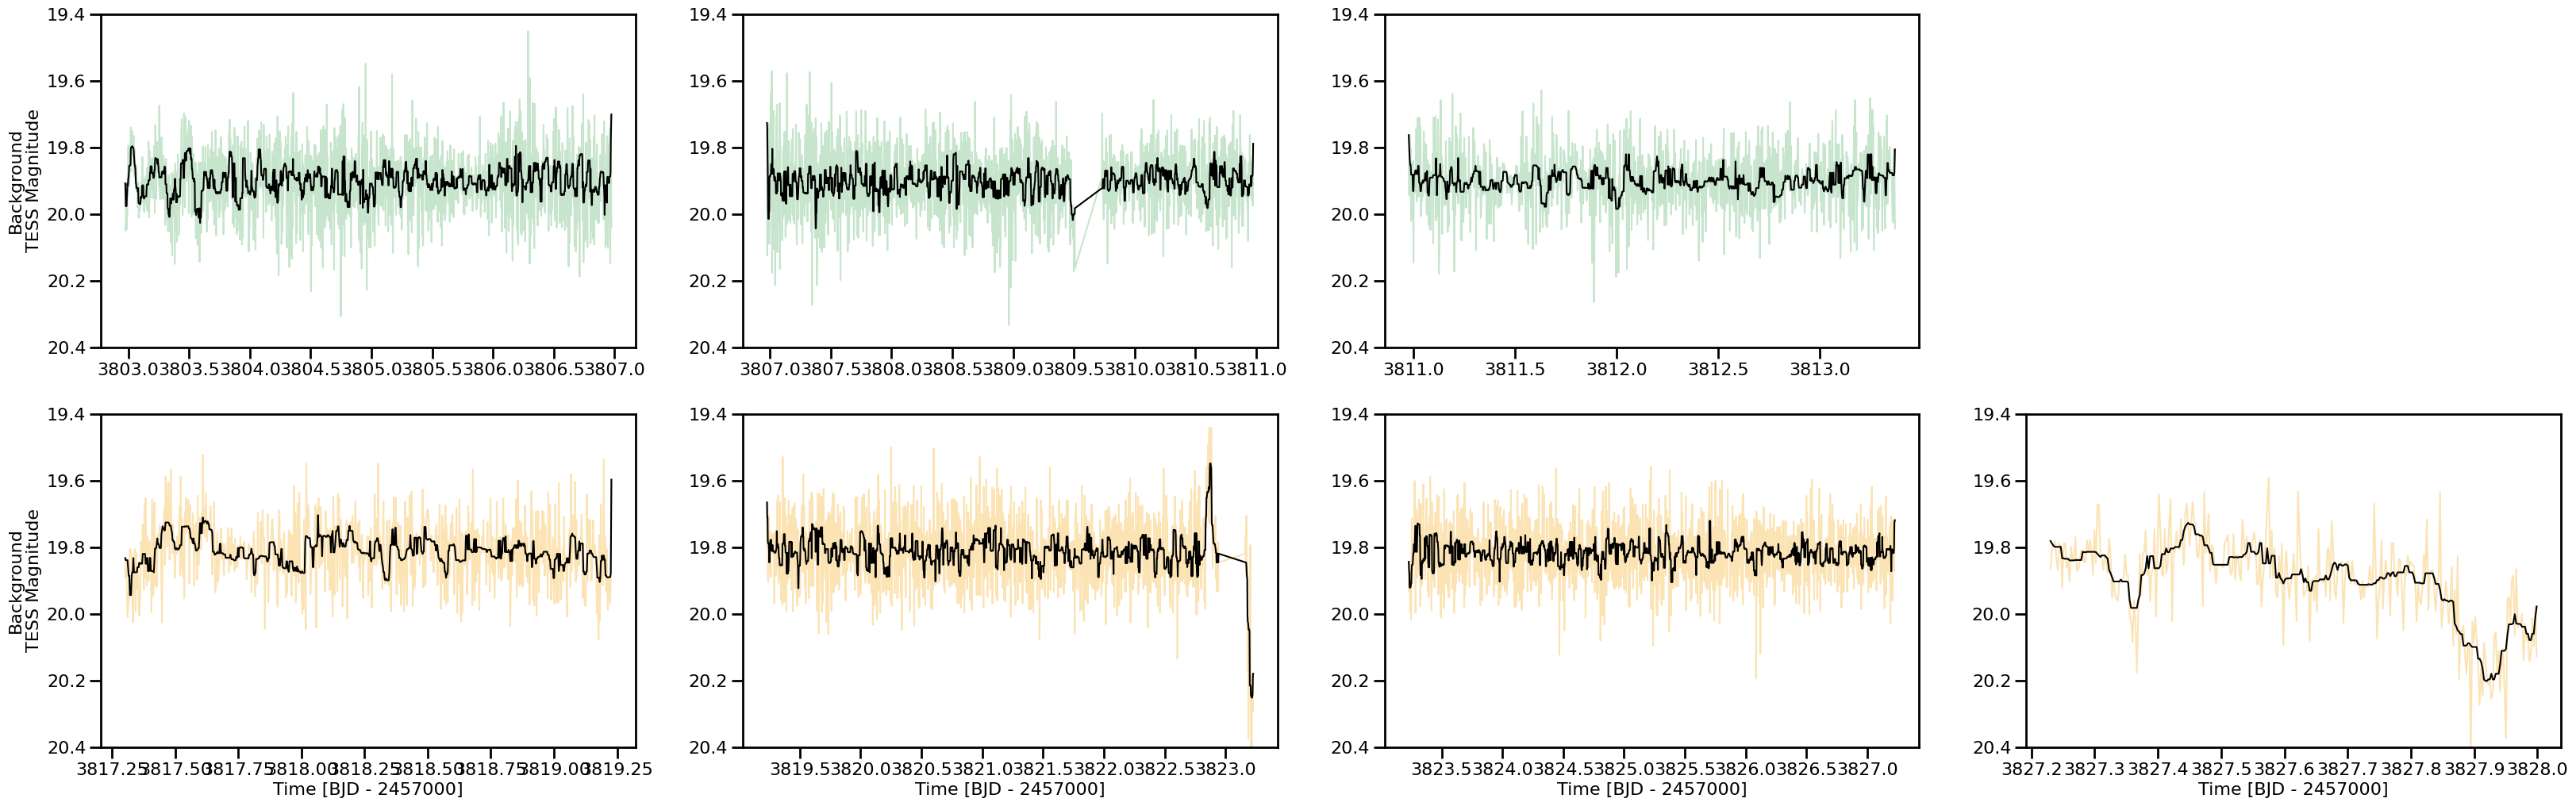

In [121]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40,12))
axes = axes.reshape(-1)
fig.set_facecolor('w')

for i in range(len(chunks1)-1):
    q = (time1 >= chunks1[i]) & (time1 < chunks1[i+1])
    axes[i].plot(time1[q], bkg1[q], color=parula[150], alpha=0.4)

    m = medfilt(bkg1[q], 11)
    axes[i].plot(time1[q], m, color='k')


for i in range(len(chunks2)-1):
    q = (time2 >= chunks2[i]) & (time2 < chunks2[i+1]) & (time2 > 3817.3) & (time2 < 3828)
    axes[i+4].plot(time2[q], bkg2[q], color=parula[210], alpha=0.4)

    m = medfilt(bkg2[q], 11)
    axes[i+4].plot(time2[q], m, color='k')

axes[3].set_axis_off()

axes[0].set_ylabel('Background\nTESS Magnitude')
axes[4].set_ylabel('Background\nTESS Magnitude')

for i in range(4,8):
    axes[i].set_xlabel('Time [BJD - 2457000]')

for i in range(len(axes)):
    axes[i].set_ylim(20.4, 19.4)
    axes[i].set_rasterized(True)

plt.savefig('../figures/broken_background_lc.png', bbox_inches='tight', dpi=350)

## Periodograms

In [28]:
def periodogram(t, f, maxp=1*units.hour, minp=3*units.day):
    med = medfilt(f, 11)
    ls = LombScargle(t*units.day, med).autopower(minimum_frequency=1.0/minp.to(units.day), 
                                                 maximum_frequency=1.0/maxp.to(units.day))
    return ls, med

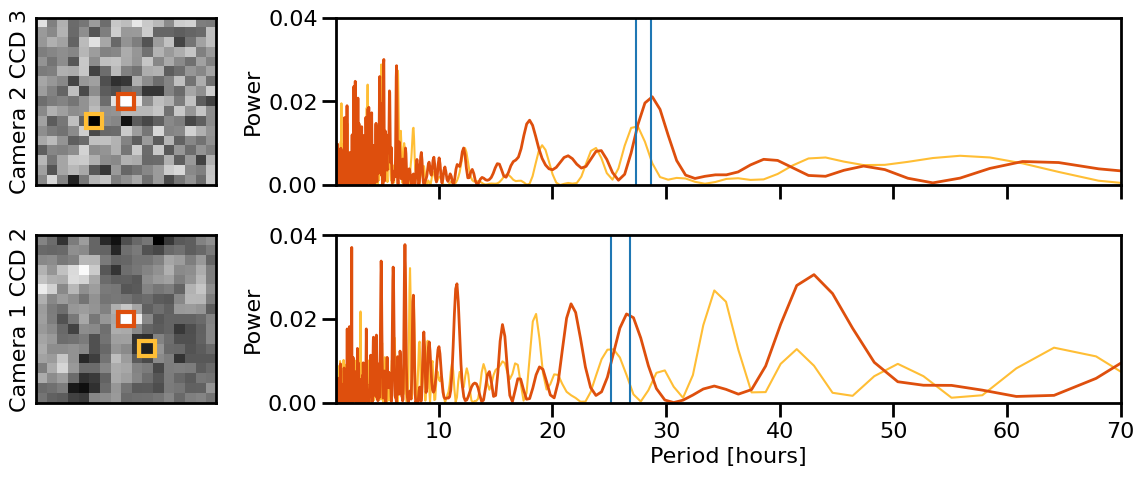

In [138]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14,5), gridspec_kw={'width_ratios':[0.23,1]})
fig.set_facecolor('w')
axes = axes.reshape(-1)

dc = '#de4f0d'#parula[60]
bc = '#ffbe35'#parula[210]

# Imshow the TPF
axes[0].imshow(np.nansum(first['subtracted'], axis=0)[2:,2:], aspect='auto', cmap='Greys_r')

# Plot the apertures
rect = Rectangle((7.25, 7.25), 1.5, 1.5, edgecolor=dc, facecolor='none', lw=3)
axes[0].add_patch(rect)

rect = Rectangle((4.25, 9.25), 1.5, 1.5, edgecolor=bc, facecolor='none', lw=3)
axes[0].add_patch(rect)


# Make the Lomb-Scargle Periodograms
bkg_23, bk23 = periodogram(time1, bkg1)
axes[1].plot((1.0/bkg_23[0]).to(units.hour), bkg_23[1], color=bc)

ls_23, m23 = periodogram(time1, medfilt(lc1, 11))
axes[1].plot((1.0/ls_23[0]).to(units.hour), ls_23[1], color=dc, lw=2)

##################
# Camera 1 CCD 2 #
##################

q = (time2 >= 3818) & (time2 < 3827.8) & (lc2 < 20.) & (bkg2 > 19.5)

# Plot the TPF
axes[2].imshow(np.nansum(second['subtracted'][second['good_frames']==1], axis=0)[2:,2:], aspect='auto',
               cmap='Greys_r')

# Plot the apertures
rect = Rectangle((7.25, 7.25), 1.5, 1.5, edgecolor=dc, facecolor='none', lw=3)
axes[2].add_patch(rect)

rect = Rectangle((9.25, 10.25), 1.5, 1.5, edgecolor=bc, facecolor='none', lw=3)
axes[2].add_patch(rect)


# Make the Lomb-Scargle Periorograms
bkg_12, mb12 = periodogram(time2[q], bkg2[q])
axes[3].plot((1.0/bkg_12[0]).to(units.hour), bkg_12[1], color=bc)

ls_12, m12 = periodogram(time2[q], medfilt(lc2[q], 11))
axes[3].plot((1.0/ls_12[0]).to(units.hour), ls_12[1], color=dc, lw=2)


axes[3].set_xlabel('Period [hours]')
for i in [1,3]:
    axes[i].set_xlim(1,70)
    axes[i].set_ylabel('Power')

for i in [0,2]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])
axes[3].set_ylim(0,0.04)
axes[1].set_ylim(0,0.04)
axes[1].set_xticklabels([])

axes[0].set_ylabel('Camera 2 CCD 3')
axes[2].set_ylabel('Camera 1 CCD 2')

axes[1].axvline(28.7)
axes[1].axvline(27.4)

axes[3].axvline(26.8)
axes[3].axvline(26.8-1.6)

for i in range(4):
    axes[i].set_rasterized(True)

plt.subplots_adjust(hspace=0.3, wspace=0.25)
#plt.savefig('../figures/ls_comparison.pdf', dpi=300, bbox_inches='tight')

In [327]:
(len(time1)*200*units.s + len(time2[q])*200*units.s).to(units.day)

<Quantity 19.48611111 d>

## Write to a table

In [139]:
tab = Table()

q = (time2 > 3816.9) & (time2 < 3828.2)

tab['time_tbjd'] = np.append(time1, time2[q])
tab['mag'] = np.append(lc1, lc2[q])

tab.write('../data/tess_lightcurve.csv', format='csv')

In [145]:
tab = Table()

q = (time2 > 3816.9) & (time2 < 3828.2)

tab['time_tbjd'] = np.append(time1, time2[q])
tab['mag'] = np.append(bkg1, bkg2[q])

tab.write('../data/tess_bkg_lightcurve.csv', format='csv')

## Significance of the pixel

In [261]:
tpf1 = np.nansum(first['subtracted'], axis=0)
tpf2 = np.nansum(second['subtracted'][second['good_frames']==1], axis=0)

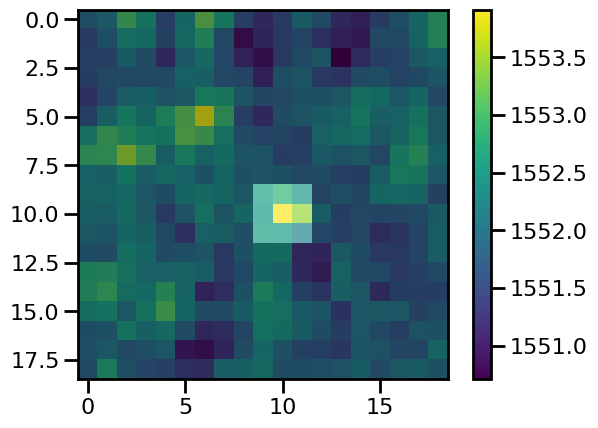

In [318]:
mask = np.ones(tpf2.shape, dtype=bool)
mask[9:12, 9:12] = False
plt.imshow(tpf2)#, vmin=1535, vmax=1555)
plt.colorbar()
plt.imshow(mask, alpha=0.3, cmap='Greys')

In [322]:
z = tpf1*mask > 0
med = np.nanmedian(tpf1[z]*mask[z])
sig = np.nanstd(tpf1[z]*mask[z])

print(med, sig)

4398.9823180929725 0.2900673628708912


In [298]:
(tpf1[10,10] - med)/sig

3.7143349330979154

In [323]:
z = tpf2*mask > 0
med = np.nanmedian(tpf2[z]*mask[z])
sig = np.nanstd(tpf2[z]*mask[z])

(tpf2[10,10]-med)/sig

4.155865798604809

In [324]:
med, sig

(1551.98019460072, 0.46541679106195927)